# Data-Driven Prediction of Concrete Strength Using Ensemble Machine Learning Methods

1. Import Modules

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib, os
import scipy.stats as stats
print('Necessary imports completed')

Necessary imports completed


2. Read and Clean Data

In [61]:
df = pd.read_csv('Concrete_Data.csv')
print('Loaded', df.shape)
display(df.head())
#Clean up Column Names
df.columns = [
                'Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer',
                'CoarseAggregate', 'FineAggregate', 'Age', 'ConcreteStrength', 'W/C', 'BFS/C', 'FA/C'
            ]


Loaded (1030, 12)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)",Water to Cement Ratio (W/C),Blast Furnace/Cement,Fly Ash/Cement
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0.300000,0.000000,0.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,0.300000,0.000000,0.0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0.685714,0.428571,0.0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0.685714,0.428571,0.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0.966767,0.666667,0.0


3. Exploratory Data Analysis

In [75]:
print('Continue running the notebook cells.')
print("Shape:", df.shape)
print(df.dtypes)
print("Missing values:\n", df.isnull().sum())
display(df.describe().T)

Continue running the notebook cells.
Shape: (1030, 12)
Cement              float64
BlastFurnaceSlag    float64
FlyAsh              float64
Water               float64
Superplasticizer    float64
CoarseAggregate     float64
FineAggregate       float64
Age                   int64
ConcreteStrength    float64
W/C                 float64
BFS/C               float64
FA/C                float64
dtype: object
Missing values:
 Cement              0
BlastFurnaceSlag    0
FlyAsh              0
Water               0
Superplasticizer    0
CoarseAggregate     0
FineAggregate       0
Age                 0
ConcreteStrength    0
W/C                 0
BFS/C               0
FA/C                0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.000000,192.375000,272.900000,350.000000,540.000000
BlastFurnaceSlag,1030.0,73.895825,86.279342,0.000000,0.000000,22.000000,142.950000,359.400000
FlyAsh,1030.0,54.188350,63.997004,0.000000,0.000000,0.000000,118.300000,200.100000
Water,1030.0,181.567282,21.354219,121.800000,164.900000,185.000000,192.000000,247.000000
Superplasticizer,1030.0,6.204660,5.973841,0.000000,0.000000,6.400000,10.200000,32.200000
CoarseAggregate,1030.0,972.918932,77.753954,801.000000,932.000000,968.000000,1029.400000,1145.000000
FineAggregate,1030.0,773.580485,80.175980,594.000000,730.950000,779.500000,824.000000,992.600000
Age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
ConcreteStrength,1030.0,35.817961,16.705742,2.330000,23.710000,34.445000,46.135000,82.600000
W/C,1030.0,0.748269,0.314005,0.266893,0.533333,0.675349,0.935014,1.882353


4. Removing Outliers

In [63]:
# Remove outliers from each numeric column
def remove_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df_clean = remove_outliers_iqr(df)
print(df.shape, "→ after removing outliers →", df_clean.shape)

(1030, 12) → after removing outliers → (845, 12)


5. Assign Target Feature

In [64]:
possible_targets = [c for c in df.columns if 'strength' in c.lower() or 'compressive' in c.lower()]
target_col = possible_targets[0] if possible_targets else df.columns[-1]
print("Target column:", target_col)

Target column: ConcreteStrength


6. Histogram Plot of all the Features

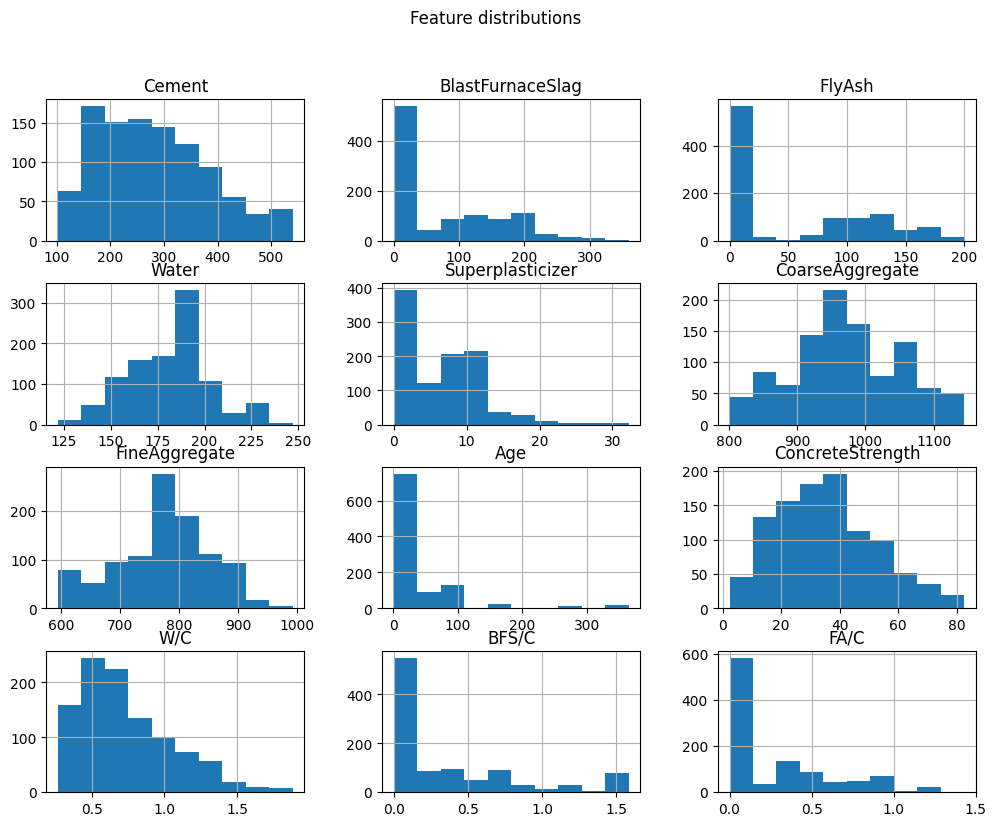

In [65]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols].hist(figsize=(12,9))
plt.suptitle("Feature distributions")
plt.show()


7. Distribution Plot

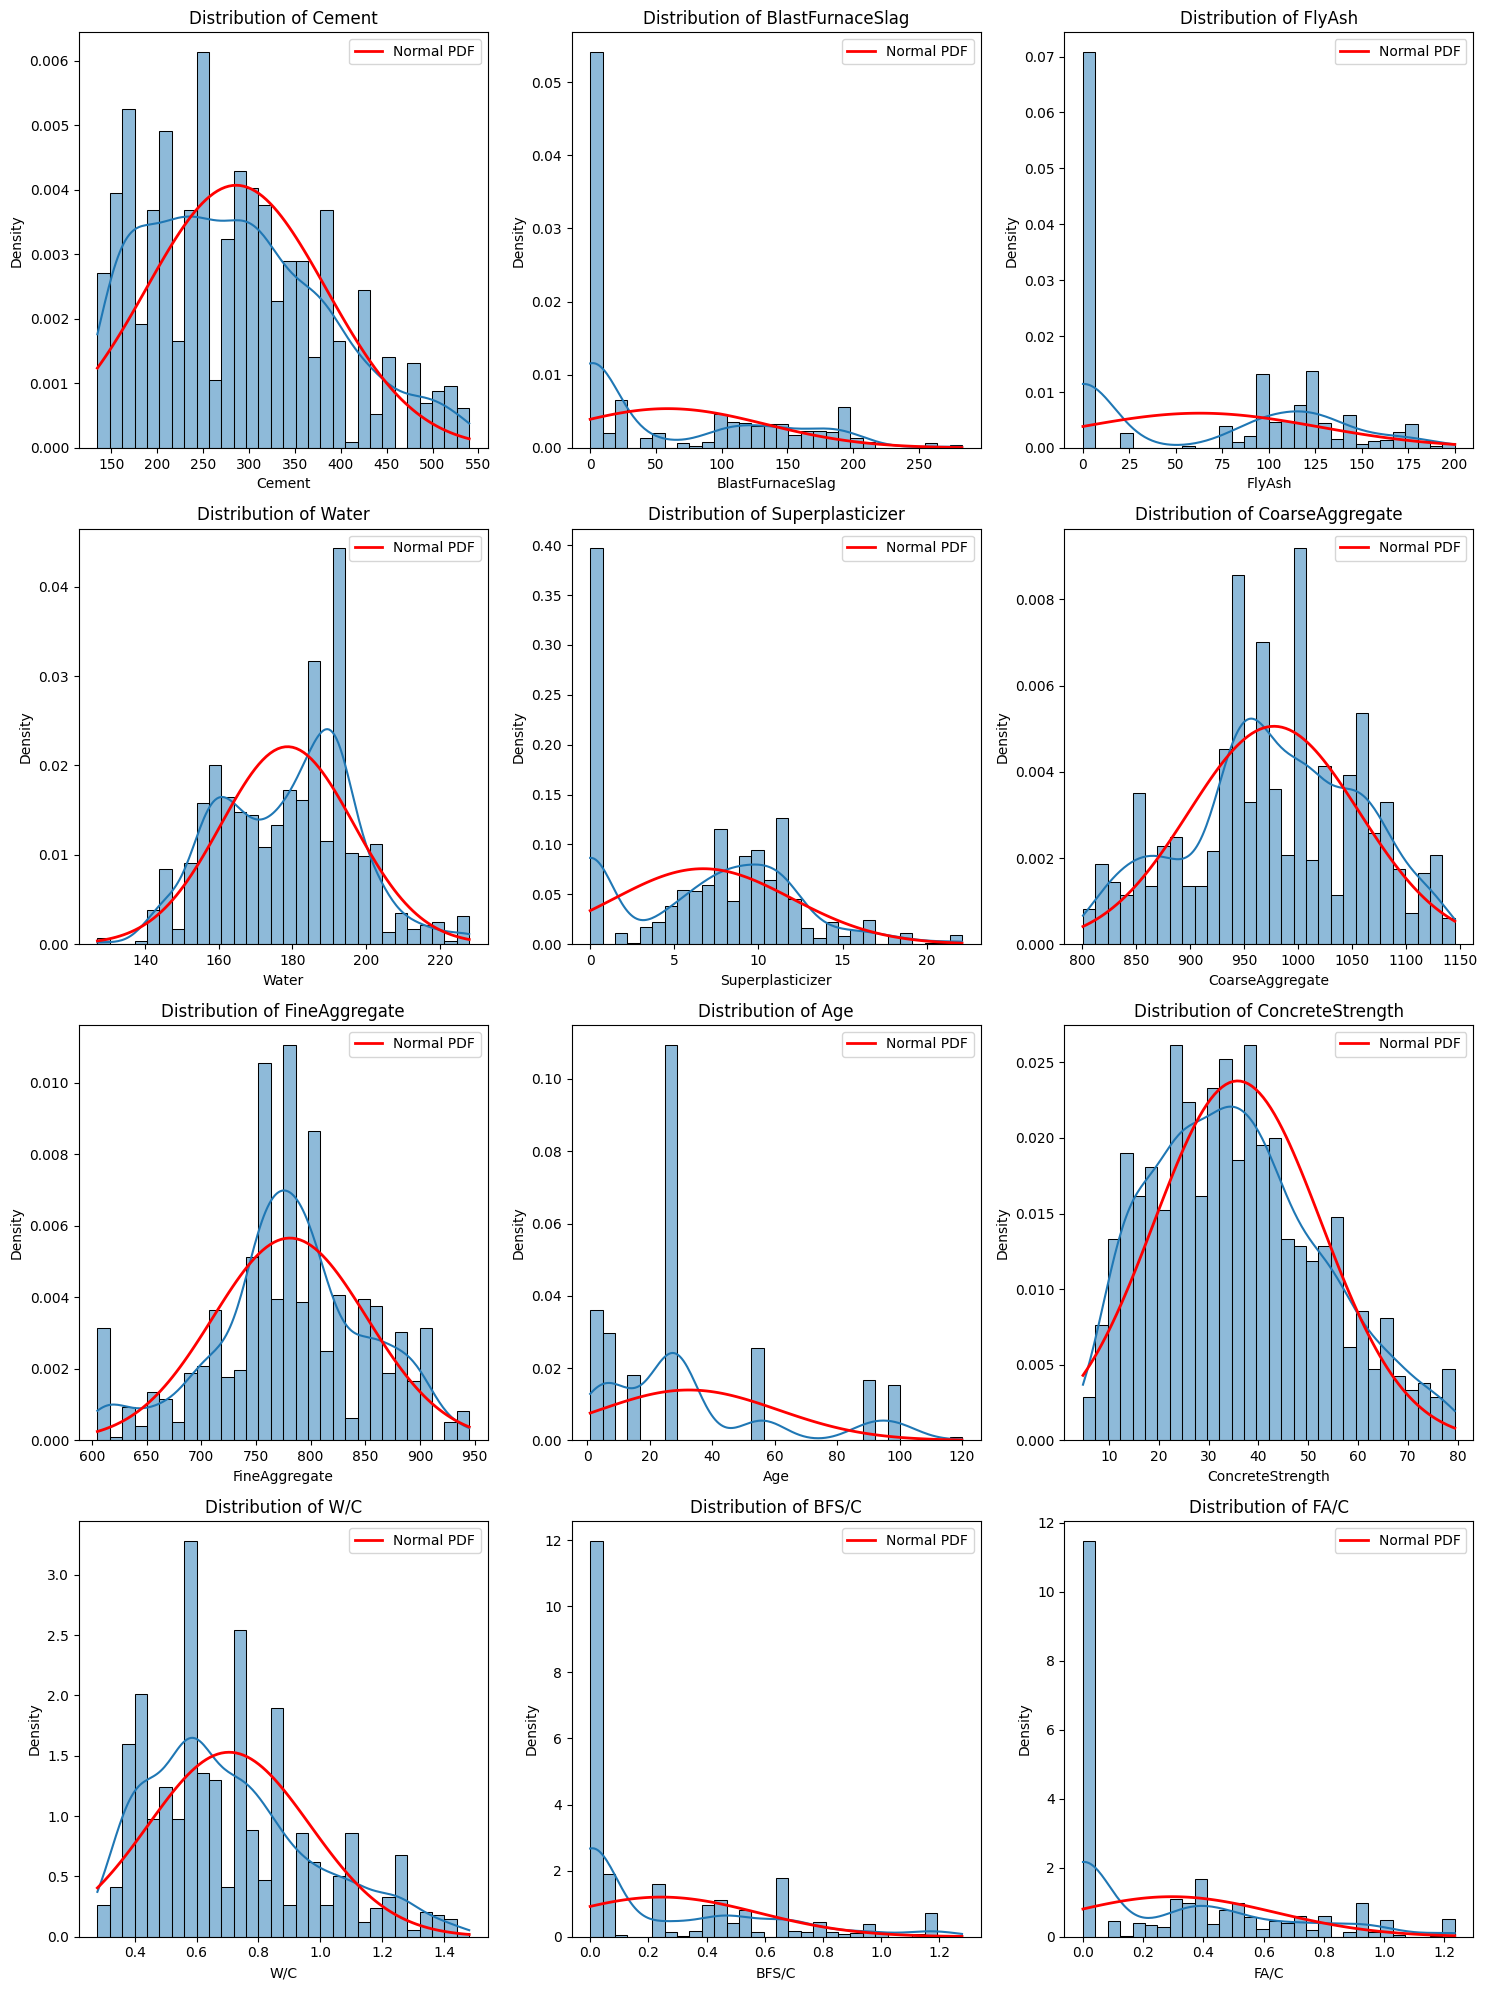

In [66]:
ncols = 3  # number of plots per row
nrows = int(np.ceil(len(numeric_cols) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))
axes = axes.flatten()  # make it 1D for easy indexing

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    
    # Histogram + KDE
    sns.histplot(df_clean[col], kde=True, stat="density", bins=30, ax=ax)
    
    # Overlay normal distribution curve
    mu, sigma = df_clean[col].mean(), df_clean[col].std()
    x = np.linspace(df_clean[col].min(), df_clean[col].max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r', lw=2, label="Normal PDF")
    
    ax.set_title(f"Distribution of {col}")
    ax.legend()

# Hide any extra empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Highly Skewed Features  
Age, Superplasticizer, BlastFurnaceSlag, and BFS/C: All of these distributions are heavily right-skewed. Most of their values cluster around zero, with a long tail of less common, higher values. 

Multi-Peaked Features  
Cement, Water, and W/C: These features show multiple peaks or two peaks in their distributions. This indicates there may be distinct subgroups or common formulations within the dataset, such as two frequent types of concrete mixes.  

Near-Normal Features  
FineAggregate and CoarseAggregate: These distributions are the most symmetrical and resemble a bell curve. CoarseAggregate, in particular, closely matches a normal distribution, showing a more consistent and centered range of values in the dataset.

8. Pair Plot

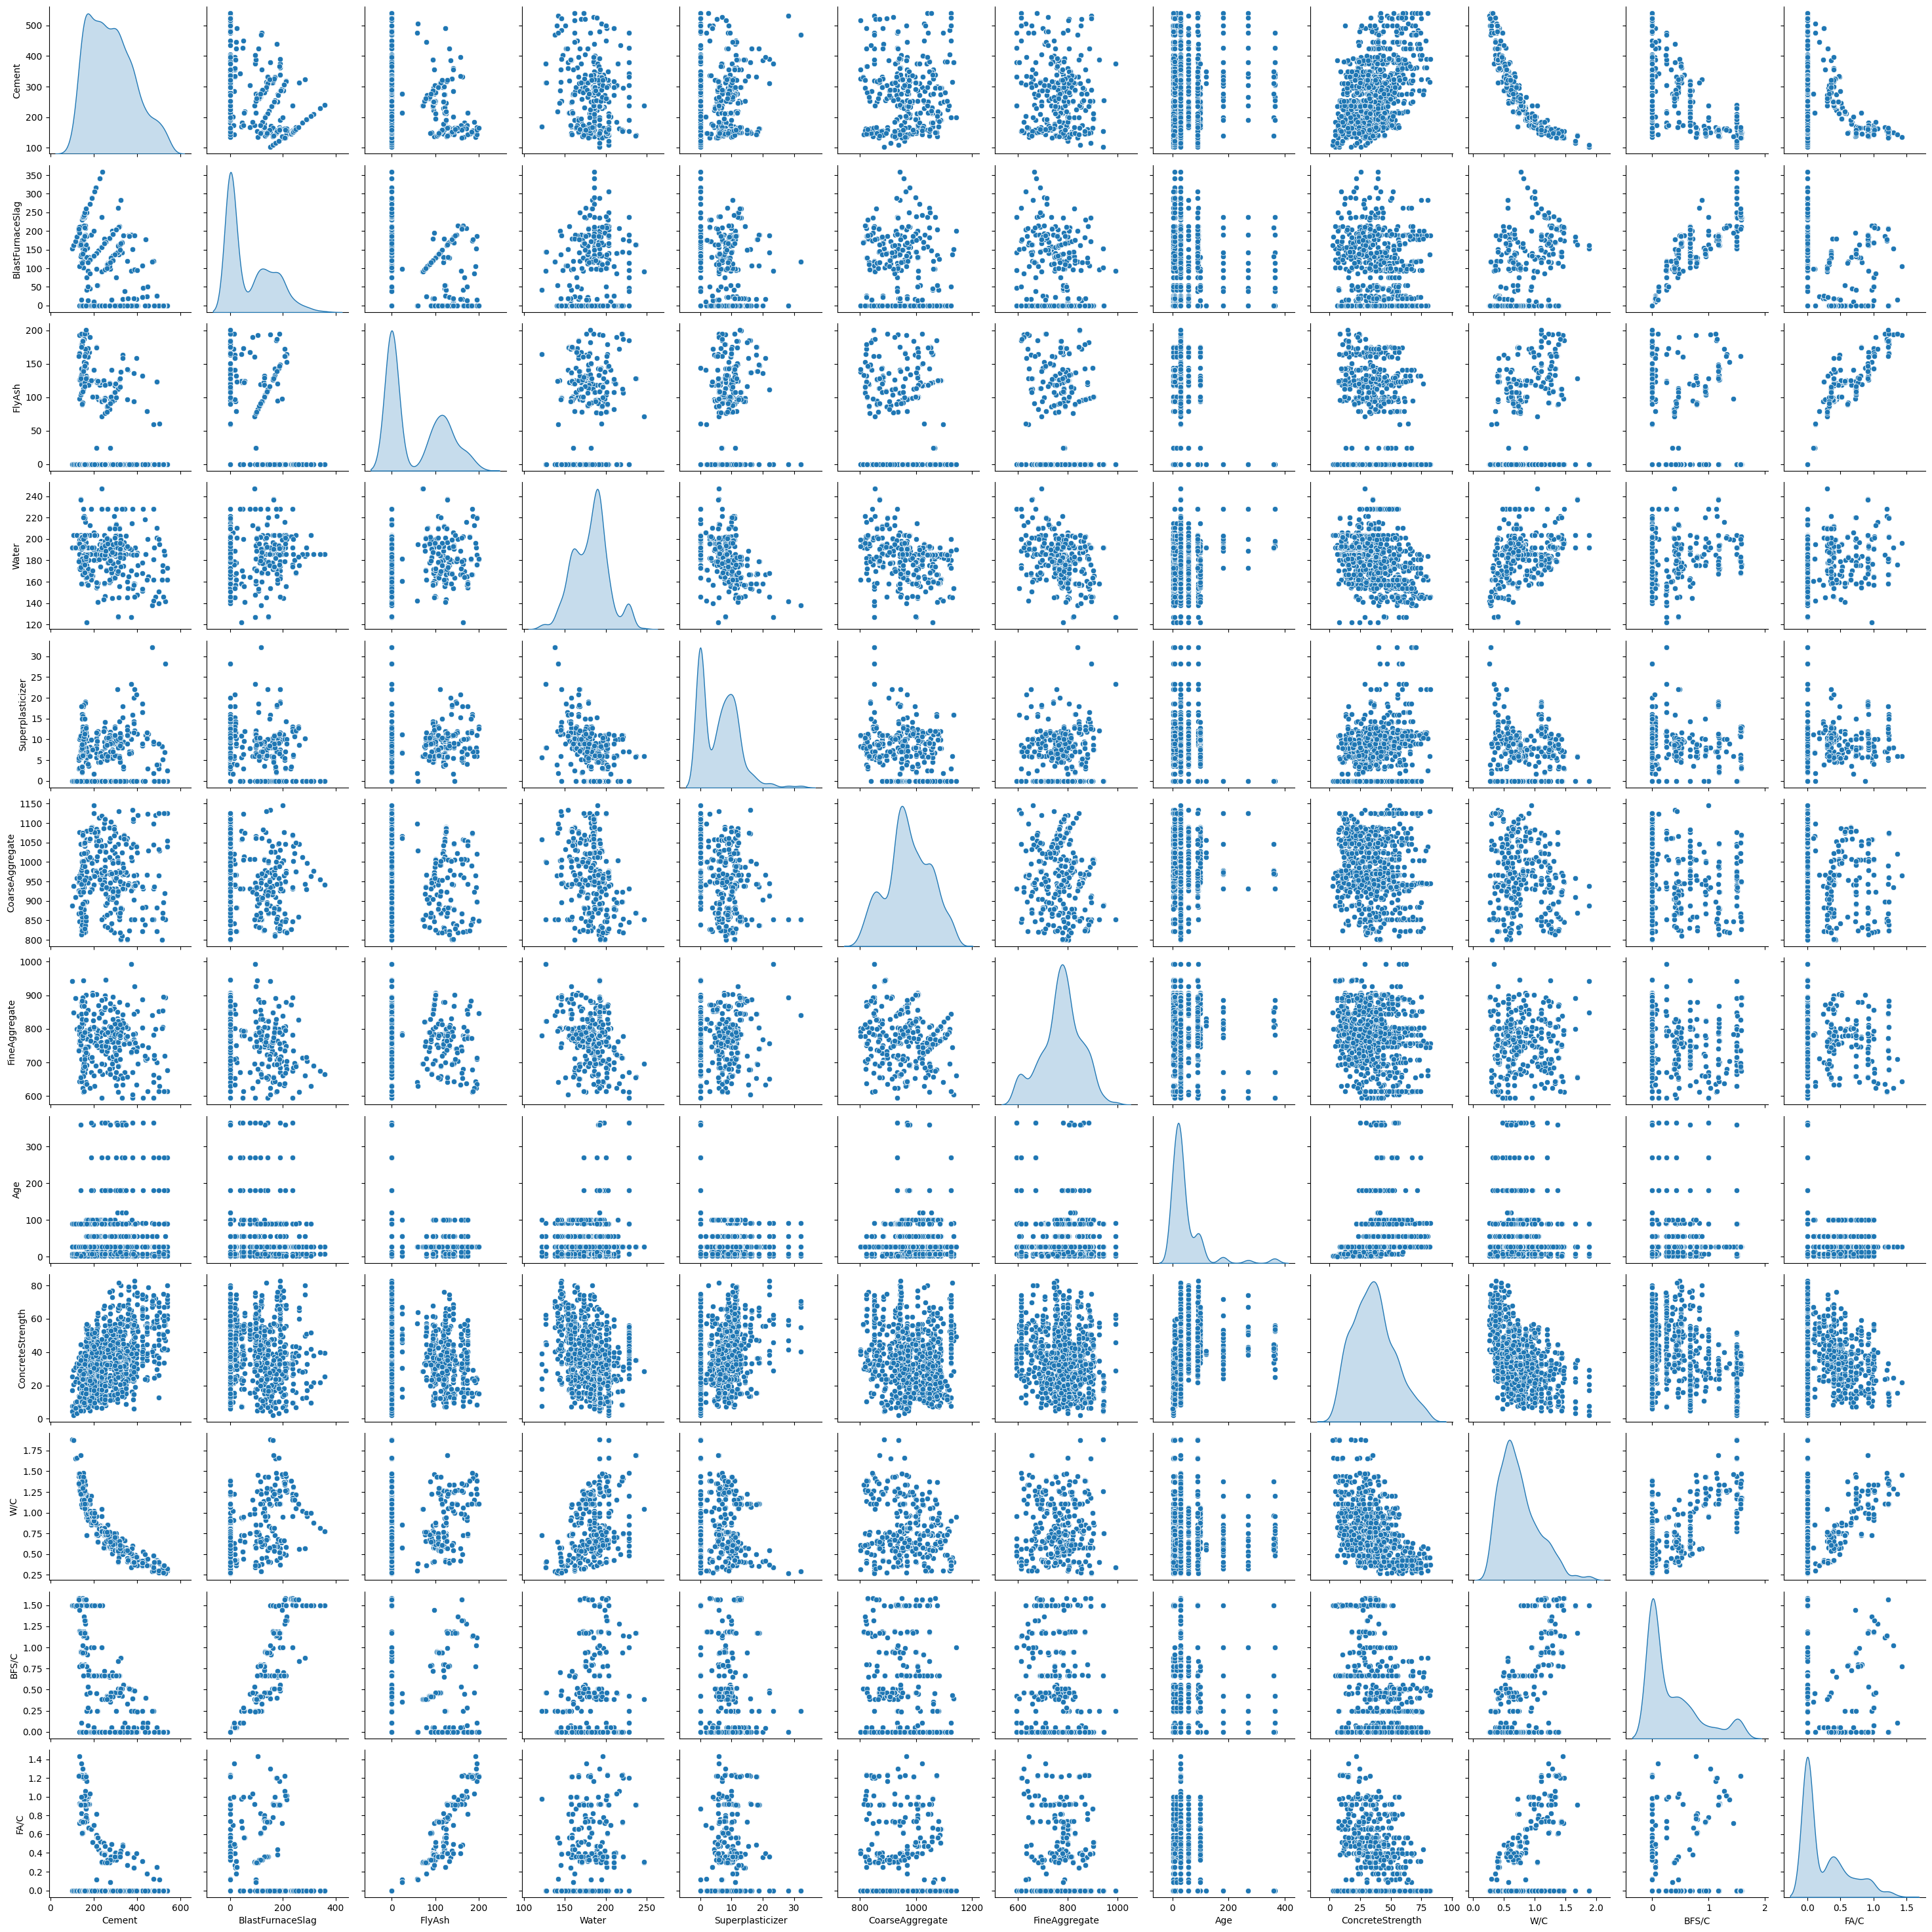

In [67]:
# Pair Plot
sns.pairplot(df, diag_kind='kde')
plt.show()

Diagonal Plots: The plots along the diagonal show the distribution for each variable. Many variables do not follow a normal distribution. Some are skewed, leaning to one side, while others have multiple peaks.

Off-Diagonal Plots: These scatter plots display the relationship between every pair of variables. The most notable finding is the overall absence of strong linear relationships. Most plots appear as scattered point clouds, indicating little to no linear correlation between the variables.

Data Structure: Some plots show distinct vertical or horizontal lines of dots. This suggests that some variables are discrete, meaning they take on only a few specific values instead of a continuous range.

9. Correlation Heatmap

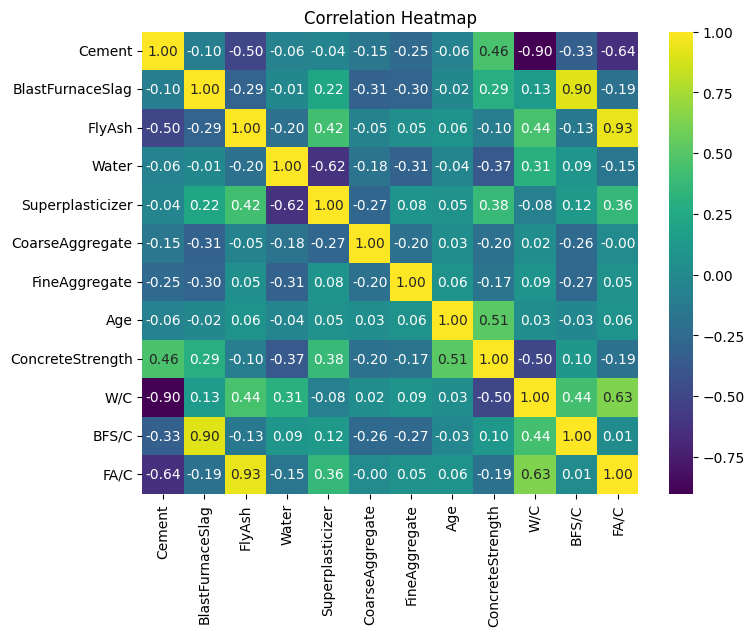

In [68]:
corr = df_clean.corr()
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='viridis')
plt.title("Correlation Heatmap")
plt.show()

10. Preprocessing

In [69]:
# Drop rows with NA (or impute) - on cleaned data
df_clean = df_clean.dropna()

# Split features & label
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col].values

# If any non-numeric columns exist, one-hot encode
X = pd.get_dummies(X, drop_first=True)

# Train-test split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Scaling (safe for linear models, optional for tree models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


11. Baseline Models

In [70]:

def metrics(y_true, y_pred):
    return {
        "r2": r2_score(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred))
    }

models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=200),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
}

# Create separate dictionaries to hold the results
train_results = {}
test_results = {}

for name, model in models.items():
    # 1. Fit the model
    model.fit(X_train_scaled, y_train)

    # 2. Get metrics for the TRAINING set
    train_preds = model.predict(X_train_scaled)
    train_results[name] = metrics(y_train, train_preds)
    

    # 3. Get metrics for the TESTING set 
    test_preds = model.predict(X_test_scaled)
    test_results[name] = metrics(y_test, test_preds)
    
    
# Convert results to DataFrames for easy viewing
train_df = pd.DataFrame(train_results).T
test_df = pd.DataFrame(test_results).T

print("Training Set Metrics")
print(train_df)
print("\nTesting Set Metrics")
print(test_df)    

Training Set Metrics
                        r2       mae      rmse
Linear            0.780583  5.924774  7.733829
RandomForest      0.987051  1.307485  1.878784
GradientBoosting  0.959902  2.513435  3.306131
CatBoost          0.990687  1.144924  1.593300

Testing Set Metrics
                        r2       mae      rmse
Linear            0.758629  6.583678  8.644025
RandomForest      0.902025  3.563896  5.507192
GradientBoosting  0.892891  3.921955  5.758204
CatBoost          0.925543  2.757687  4.800939


12. Hyperparameter tuning (RandomizedSearchCV) for CATBOOST

In [71]:
# 1. DEFINE PARAMETER DISTRIBUTION FOR CATBOOST
param_dist = {
    "iterations": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "depth": [4, 6, 8, 10],
    "subsample": [0.6, 0.8, 1.0],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "min_data_in_leaf": [1, 3, 5]
}

# Note: if dataset is small, reduce n_iter and cv:
n_samples = X.shape[0]
cv_folds = min(5, max(2, n_samples//10))  # heuristic
n_iter_search = 20 if n_samples >= 200 else 8

# 2. INSTANTIATE THE CATBOOST MODEL AND RANDOMIZEDSEARCHCV
cbr = CatBoostRegressor(random_state=42, verbose=0) # Use verbose=0 to keep output clean
rs = RandomizedSearchCV(cbr, param_distributions=param_dist,
                        n_iter=n_iter_search, cv=cv_folds, scoring='r2',
                        random_state=42, n_jobs=-1, verbose=1)

# 3. FIT THE MODEL
rs.fit(X_train_scaled, y_train)



print("Best params for CatBoost:", rs.best_params_)
best_model = rs.best_estimator_

# Evaluate best model
preds_best = best_model.predict(X_test_scaled)
metrics_best = metrics(y_test, preds_best)
print("Best CatBoost model metrics:", metrics_best)

# Cross-validated score on full dataset (optional)
cv_score = cross_val_score(best_model, scaler.transform(X), y, cv=cv_folds, scoring='r2')
print("CV R2 mean (best CatBoost model):", cv_score.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for CatBoost: {'subsample': 0.8, 'min_data_in_leaf': 5, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 6}
Best CatBoost model metrics: {'r2': 0.932341211916509, 'mae': 2.603161323893487, 'rmse': np.float64(4.576524199226285)}
CV R2 mean (best CatBoost model): 0.6875577796064676


A hyperparameter search was done to find the best settings for the model. The best version performs very well, achieving an R-squared (R²) of 0.93 and an average error (MAE) of 2.6 on the test data. This means it explains about 93% of the data's variance.

However, the average R² score during cross-validation was a more modest 0.69. This difference suggests that while the model is strong, its high performance might not be consistent on all new data. One possible reason could be that the dataset is small, which makes the CV splits unstable. Another reason might be that after the hyperparameter search, the model overfits the training folds, so cross-validation does not look perfect.

13. Feature Importance and Interpretability

Age                 33.000015
W/C                 26.204236
Superplasticizer     8.602456
BFS/C                6.627468
Cement               6.153007
Water                6.000157
FineAggregate        3.969309
BlastFurnaceSlag     3.318735
CoarseAggregate      3.123486
FA/C                 1.712355
dtype: float64

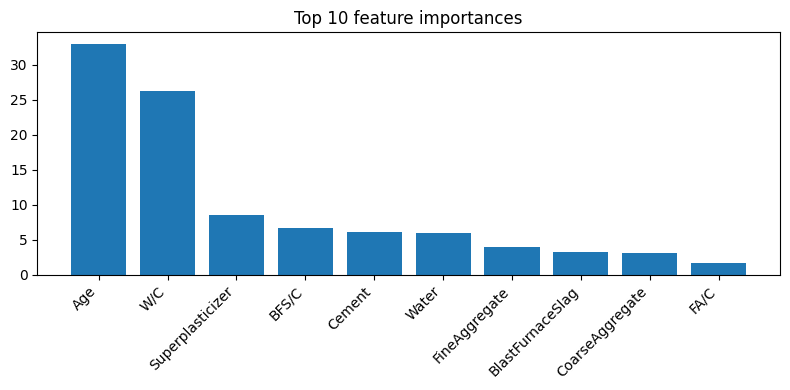

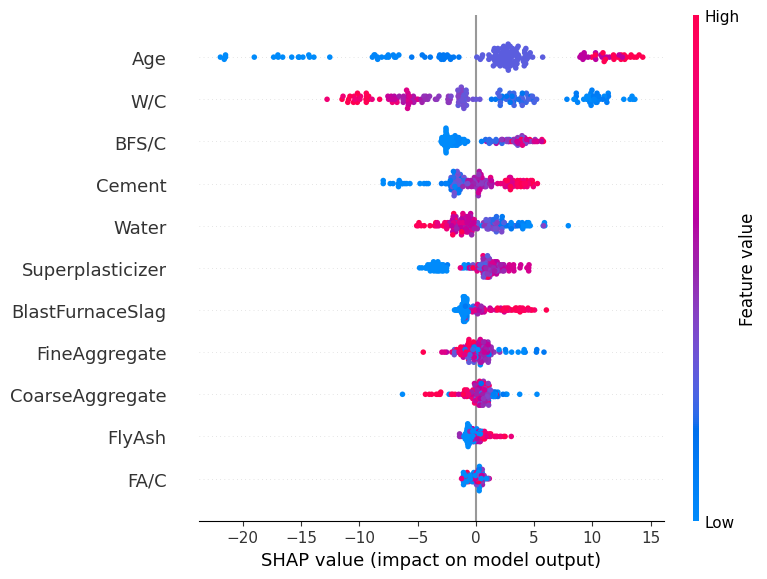

In [72]:
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.head(10))
plt.figure(figsize=(8,4))
plt.bar(importances.index[:10], importances.values[:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 feature importances")
plt.tight_layout()
plt.show()

#Run SHAP for per-sample explanations:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

*Interpretation of SHAP Plot*
Direction of impact:

Age: Higher age (red points) → positive SHAP values → increases predicted strength.

W/C: Higher ratio (red) → negative SHAP values → lowers predicted strength.

Cement: Higher cement content (red) → positive SHAP values → increases predicted strength.

Water: Higher water content (red) → negative SHAP values → reduces strength.

14. Optimization Routine (search-based)

In [73]:
# Note: sample candidate mixes within observed ranges, predict, and pick those close to target.
feature_ranges = {col: (X[col].min(), X[col].max()) for col in X.columns}

def suggest_mixes(target_strength, n_candidates=10000, top_k=10, tolerance=None, prefer_low_cement=True):
    rng = np.random.RandomState(0)
    candidates = pd.DataFrame({col: rng.uniform(low, high, n_candidates) for col, (low, high) in feature_ranges.items()})
    # If 'Age' present, consider rounding to nearest whole day
    age_cols = [c for c in candidates.columns if 'age' in c.lower()]
    for a in age_cols:
        candidates[a] = np.clip(np.round(candidates[a]), feature_ranges[a][0], feature_ranges[a][1])
    # Predict
    cand_scaled = scaler.transform(candidates)
    preds = best_model.predict(cand_scaled)
    candidates['pred_strength'] = preds
    candidates['abs_err'] = np.abs(preds - target_strength)
    if tolerance is not None:
        candidates = candidates[candidates['abs_err'] <= tolerance]
    if candidates.shape[0] == 0:
        top = candidates.nsmallest(top_k, 'abs_err')
    else:
        if prefer_low_cement and 'Cement (component 1)(kg in a m^3 mixture)' in candidates.columns:
            top = candidates.sort_values(['abs_err', 'Cement (component 1)(kg in a m^3 mixture)']).head(top_k)
        else:
            top = candidates.nsmallest(top_k, 'abs_err')
    return top

# Example usage:
suggested = suggest_mixes(target_strength=40.0, n_candidates=5000, top_k=5)
display(suggested)


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,W/C,BFS/C,FA/C,pred_strength,abs_err
1446,502.671245,163.000181,95.565689,162.021692,5.120219,1135.529725,725.799170,84.0,1.184360,1.090587,0.778701,40.001576,0.001576
2389,326.175411,62.121124,8.396753,159.501070,14.679118,951.282531,939.630454,27.0,0.943892,0.915610,1.224228,40.006945,0.006945
3496,322.221409,32.553307,8.534541,171.888158,15.283822,926.247397,764.578038,19.0,0.596214,0.105978,0.138037,39.988002,0.011998
1981,426.938893,52.781819,2.496457,157.861044,5.481657,834.869175,741.766510,69.0,1.007235,0.178304,0.108558,40.013552,0.013552
3075,289.870445,237.573784,56.894471,173.618086,12.612667,958.858756,890.334983,27.0,0.801765,0.369232,0.303268,39.986424,0.013576


15. Summary

In [74]:
print("Best Model Performance (on Test Set): CATBOOST")
# Print each metric on a new line, formatted to 4 decimal places
for metric_name, value in metrics_best.items():
    print(f"{metric_name.upper()}: {value:.4f}")

print("\nTop 5 Feature Importances")
# Display the top 5 features from the pre-calculated 'importances' Series
display(importances.head(5))

print("\nSuggested Concrete Mixes (Example for 40 MPa Target)")
# Display the 'suggested' DataFrame that was generated earlier
display(suggested)

Best Model Performance (on Test Set): CATBOOST
R2: 0.9323
MAE: 2.6032
RMSE: 4.5765

Top 5 Feature Importances


Age                 33.000015
W/C                 26.204236
Superplasticizer     8.602456
BFS/C                6.627468
Cement               6.153007
dtype: float64


Suggested Concrete Mixes (Example for 40 MPa Target)


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,W/C,BFS/C,FA/C,pred_strength,abs_err
1446,502.671245,163.000181,95.565689,162.021692,5.120219,1135.529725,725.799170,84.0,1.184360,1.090587,0.778701,40.001576,0.001576
2389,326.175411,62.121124,8.396753,159.501070,14.679118,951.282531,939.630454,27.0,0.943892,0.915610,1.224228,40.006945,0.006945
3496,322.221409,32.553307,8.534541,171.888158,15.283822,926.247397,764.578038,19.0,0.596214,0.105978,0.138037,39.988002,0.011998
1981,426.938893,52.781819,2.496457,157.861044,5.481657,834.869175,741.766510,69.0,1.007235,0.178304,0.108558,40.013552,0.013552
3075,289.870445,237.573784,56.894471,173.618086,12.612667,958.858756,890.334983,27.0,0.801765,0.369232,0.303268,39.986424,0.013576
